# Figure 8. Parity plots of Jezica and related properties

Make sure environment is using `glasspy 0.4.6`.

In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np

In [7]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

In [8]:
formers = ['Si', 'P', 'B', 'Al']
modifiers = ['Na', 'Li', 'K', 'Cs', 'Ca', 'Mg'] # have not used yet

# Data

## Load GlassNet training and test data

In [3]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()

## Load Jezica data

In [5]:
df = pd.read_excel( f'../data/jezica.xlsx', sheet_name='Sheet1' )

In [9]:
X = df[ df.columns[:-3] ]
true_tl = df['Tliquidus (K)']
true_visc_at_tl = np.log10( df['viscosity at Tliquidus (Pa.s)'] )
true_jezica = np.log10( df['Jezica (Pa.s / K^2)'] )

# GlassNet predictions

In [10]:
X_by_former = []
for former in formers:
    X_by_former.append( X[ X[former] >  X[ [f for f in formers if f != former] ].sum(axis=1) ] )   

In [11]:
y_pred = glassnet_stnn.predict(X)

In [12]:
pred_tl = y_pred['Tliquidus']
pred_visc_at_tl = glassnet_stnn.predict_log10_viscosity( T = pred_tl, composition = X )

In [13]:
pred_jezica = (pred_visc_at_tl ) - 2 * np.log10(pred_tl)

Si 2906 0.8206242263826183 48.985896966037735
Si 2906 0.43192705283831623 0.5538671189117766
Si 2906 0.44092636866468293 0.5811063480570051
P 36 0.8523738039956779 38.35920552573782
P 36 -0.41900712832934106 2.114416255552668
P 36 -0.49913780757702986 2.1182791650767543
B 72 0.807274631898402 40.53077505759695
B 72 -0.03417853924443515 1.1779614506975615
B 72 -0.016190953898919114 1.199530295470093
Al 6 0.26984765826373136 61.346609650913706
Al 6 -3.3119938870978656 1.5853850290523308
Al 6 -3.536589306676883 1.5852075592201416
Other 107 0.9550749361181096 50.45564353487492
Other 107 0.07477860722850382 0.9524330989942682
Other 107 0.05804229077208567 0.9823580809119156


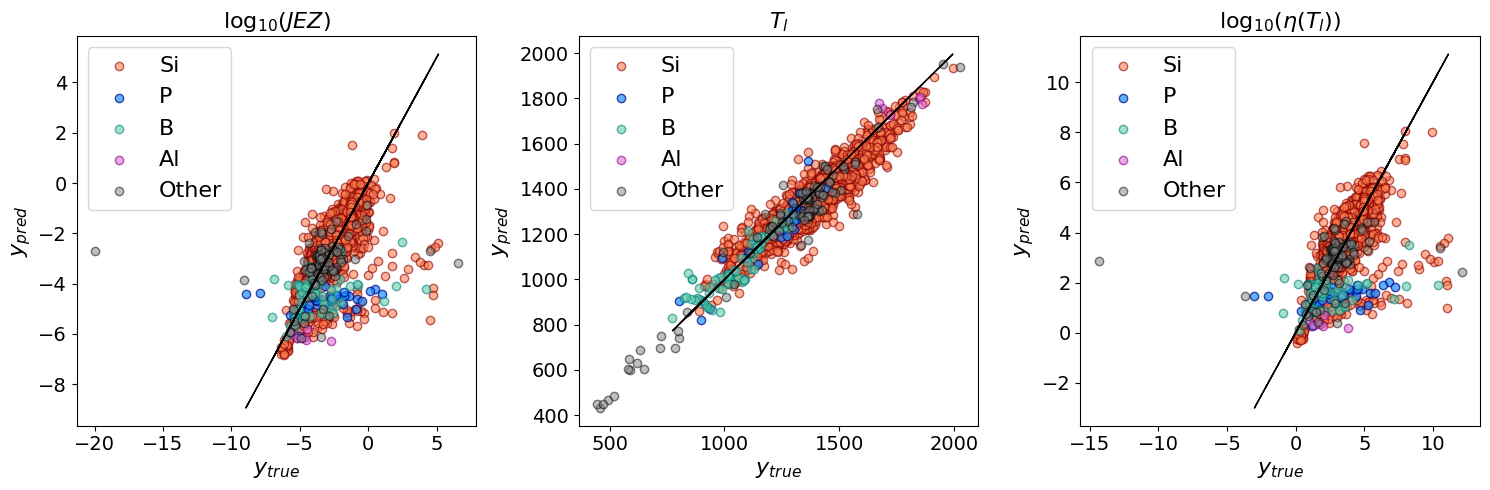

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
colors = ['coral', 'dodgerblue', 'mediumaquamarine', 'orchid']
ecolors = ['darkred', 'navy', 'teal', 'darkmagenta']
alphas = [0.6, 0.7, 0.6, 0.6]
y_true_all = []
former_inds = []
acc_arr = pd.DataFrame( np.zeros( (12,4) ), columns=['former', 'N', 'R2', 'MAE'] )

for j,former in enumerate( formers ):
    X = X_by_former[j]
    inds_test = true_tl.dropna().index.intersection( X.index )
    this_true_tl = true_tl.loc[inds_test]
    this_true_visc_at_tl = true_visc_at_tl.loc[inds_test]
    this_true_jezica = true_jezica.loc[inds_test]

    this_pred_tl = pred_tl.loc[inds_test]
    this_pred_visc_at_tl = pred_visc_at_tl.loc[inds_test]
    this_pred_jezica = pred_jezica.loc[inds_test]

    for y in this_true_jezica:
        if y not in y_true_all:
            y_true_all.append(y)
    for ind in list( inds_test ):
        former_inds.append(ind)

    ax[0].scatter(this_true_jezica, this_pred_jezica, marker='o', color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former)
    ax[1].scatter(this_true_tl, this_pred_tl, marker='o', color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former,)
    ax[2].scatter(this_true_visc_at_tl, this_pred_visc_at_tl, marker='o', color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former,)

    ax[0].plot(this_true_jezica, this_true_jezica, color='black',linewidth=1.0)
    ax[1].plot(this_true_tl, this_true_tl, color='black',linewidth=1.0)
    ax[2].plot(this_true_visc_at_tl, this_true_visc_at_tl, color='black',linewidth=1.0)

    ax[0].set_xlabel(r'$y_{true}$')
    ax[0].set_ylabel(r'$y_{pred}$')
    ax[0].set_title('$\mathrm{log}_{10}(JEZ)$')

    ax[1].set_xlabel(r'$y_{true}$')
    ax[1].set_ylabel(r'$y_{pred}$')
    ax[1].set_title('$T_l$')

    ax[2].set_xlabel(r'$y_{true}$')
    ax[2].set_ylabel(r'$y_{pred}$')
    ax[2].set_title('$\mathrm{log}_{10}(\eta(T_l))$')

    
    print(former, len(this_true_tl), r2_score( this_true_tl, this_pred_tl), mean_absolute_error( this_true_tl, this_pred_tl) )
    print(former, len(this_true_visc_at_tl), r2_score( this_true_visc_at_tl, this_pred_visc_at_tl), mean_absolute_error( this_true_visc_at_tl, this_pred_visc_at_tl) )
    print(former, len(this_true_jezica), r2_score( this_true_jezica, this_pred_jezica), mean_absolute_error( this_true_jezica, this_pred_jezica) )
    
inds_test = [ i for i in list(true_jezica.index) if i not in former_inds ]
this_true_tl = true_tl.loc[inds_test]
this_true_visc_at_tl = true_visc_at_tl.loc[inds_test]
this_true_jezica = true_jezica.loc[inds_test]

this_pred_tl = pred_tl.loc[inds_test]
this_pred_visc_at_tl = pred_visc_at_tl.loc[inds_test]
this_pred_jezica = pred_jezica.loc[inds_test]

ax[0].scatter(this_true_jezica, this_pred_jezica, marker='o', color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
ax[1].scatter(this_true_tl, this_pred_tl, marker='o', color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
ax[2].scatter(this_true_visc_at_tl, this_pred_visc_at_tl, marker='o', color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
ax[0].legend()
ax[1].legend()
ax[2].legend()

print('Other', len(this_true_tl), r2_score( this_true_tl, this_pred_tl), mean_absolute_error( this_true_tl, this_pred_tl) )
print('Other', len(this_true_visc_at_tl), r2_score( this_true_visc_at_tl, this_pred_visc_at_tl), mean_absolute_error( this_true_visc_at_tl, this_pred_visc_at_tl) )
print('Other', len(this_true_jezica), r2_score( this_true_jezica, this_pred_jezica), mean_absolute_error( this_true_jezica, this_pred_jezica) )
fig.savefig('figure8.png', dpi=600)